In [1]:
from pathlib import Path
import numpy as np
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from scipy.fft import fft, fftfreq

from pulse import (
    load_all_signals,
    compute_fourier_frequencies,
)
from pulse.helpers import preprocess_signal
from pulse.ssa_analysis import ssa_decompose, fit_sinusoid


init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2

In [2]:
SAMPLING_RATE = 100.0
L = 50
DATA_DIR = Path("../data/signals/")
SIGNAL_FILENAMES = list(DATA_DIR.glob("*"))
N = 1

signals = load_all_signals(DATA_DIR)
print(f"Загружено сигналов: {len(signals)}")
print(f"Размер каждого сигнала: {signals[0].shape if len(signals) > 0 else 'N/A'}")

subsample_signals = signals[:N]
print(f"В анализе участвует {subsample_signals.shape}")

Загружено сигналов: 827
Размер каждого сигнала: (10000,)
В анализе участвует (1, 10000)


## Фурье-разложение

In [3]:
fourier_frequencies = compute_fourier_frequencies(signals, sampling_rate=SAMPLING_RATE)
filtered_signals = np.array(signals)
filtered_frequencies = fourier_frequencies[
    (40 < fourier_frequencies * 60) & (fourier_frequencies * 60 < 180)
]
print(f"Вычислено частот по Фурье: {len(filtered_frequencies)}")
print(
    f"Диапазон частот Фурье: [{np.min(filtered_frequencies):.4f}, {np.max(filtered_frequencies):.4f}] Гц / [{np.min(filtered_frequencies) * 60:.1f}, {np.max(filtered_frequencies) * 60:.1f}] BPM"
)

Вычислено частот по Фурье: 754
Диапазон частот Фурье: [1.0500, 1.8400] Гц / [63.0, 110.4] BPM


## SSA

### Быстрое усреднение

In [4]:
all_components = {}
filtered_signals = np.array(signals)[
    (40 < fourier_frequencies * 60) & (fourier_frequencies * 60 < 180)
]
filtered_names = np.array(SIGNAL_FILENAMES)[
    (40 < fourier_frequencies * 60) & (fourier_frequencies * 60 < 180)
]
for signal, filename in tqdm(
    zip(filtered_signals, filtered_names), total=len(filtered_signals), desc="SSA processed"
):
    components = ssa_decompose(
        preprocess_signal(signal, normalize=True), window_size=L, n_components=5, fast=True
    )
    all_components[filename] = components

SSA processed: 100%|██████████| 754/754 [05:33<00:00,  2.26it/s]


### Обычное усреднение

In [4]:
all_components = {}
filtered_signals = np.array(signals)[
    (40 < fourier_frequencies * 60) & (fourier_frequencies * 60 < 180)
]
filtered_names = np.array(SIGNAL_FILENAMES)[
    (40 < fourier_frequencies * 60) & (fourier_frequencies * 60 < 180)
]
for signal, filename in tqdm(
    zip(filtered_signals, filtered_names), total=len(filtered_signals), desc="SSA processed"
):
    components = ssa_decompose(
        preprocess_signal(signal, normalize=True), window_size=L, n_components=5
    )
    all_components[filename] = components

SSA processed: 100%|██████████| 754/754 [20:25<00:00,  1.63s/it]


### Сохранение

In [5]:
with open("../data/processed/all_components_slow.pkl", "wb") as f:
    pickle.dump(all_components, f)

In [ ]:
with open("all_components.pkl", "rb") as f:
    all_components = pickle.load(f)

In [5]:
components_df = pd.DataFrame(all_components).T
components_df["path"] = components_df.index
components_df["freqs"] = components_df[1].apply(lambda x: fit_sinusoid(x, sampling_rate=100)[0])

In [6]:
components_df["freqs"].describe()

count    754.000000
mean       1.595308
std        1.034655
min        0.670000
25%        0.670000
50%        1.217521
75%        3.000000
max        3.000000
Name: freqs, dtype: float64

## Визуализации

In [7]:
def plot_signal(idx):
    clear_output(wait=True)
    signal = preprocess_signal(filtered_signals[idx], verbose=False)
    try:
        filename = filtered_names[idx]
    except NameError:
        filename = Path(f"signal_{idx}")

    # Получаем компоненты SSA
    components = all_components.get(filename, [])

    # Вычисляем FFT для АЧХ
    n = len(signal)
    fft_values = fft(signal)
    fft_magnitude = np.abs(fft_values)
    frequencies = fftfreq(n, 1 / SAMPLING_RATE)

    # Ограничиваем только положительными частотами до 5 Гц
    positive_mask = (frequencies > 0) & (frequencies <= 5.0)
    positive_frequencies = frequencies[positive_mask]
    positive_magnitude = fft_magnitude[positive_mask]

    # Восстанавливаем сигнал из компонент SSA
    reconstructed = (
        np.sum(np.vstack(components) * np.std(signal), axis=0) if len(components) > 0 else signal
    )

    fig = make_subplots(
        rows=4,
        cols=1,
        subplot_titles=(
            "Исходный сигнал",
            "АЧХ Фурье",
            "Восстановленный сигнал (SSA)",
            "Компоненты SSA",
        ),
        vertical_spacing=0.12,
        horizontal_spacing=0.1,
    )

    # График 1: Исходный сигнал
    fig.add_trace(
        go.Scatter(
            x=np.arange(len(signal)),
            y=signal,
            mode="lines",
            name="Исходный сигнал",
            line=dict(color="blue", width=1.5),
            showlegend=False,
        ),
        row=1,
        col=1,
    )

    # График 2: АЧХ Фурье
    fig.add_trace(
        go.Scatter(
            x=positive_frequencies,
            y=positive_magnitude,
            mode="lines",
            name="АЧХ Фурье",
            line=dict(color="green", width=2),
            showlegend=False,
        ),
        row=2,
        col=1,
    )

    # График 3: Восстановленный сигнал
    fig.add_trace(
        go.Scatter(
            x=np.arange(len(reconstructed)),
            y=reconstructed,
            mode="lines",
            name="Восстановленный (SSA)",
            line=dict(color="red", width=1.5),
            showlegend=False,
        ),
        row=3,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=np.arange(len(signal)),
            y=signal,
            mode="lines",
            name="Исходный сигнал",
            line=dict(color="blue", width=1.5),
            showlegend=False,
        ),
        row=3,
        col=1,
    )

    # График 4: Компоненты SSA
    colors = ["purple", "orange", "brown", "pink", "gray"]
    for i, component in enumerate(components[:5]):  # Показываем первые 5 компонент
        fig.add_trace(
            go.Scatter(
                x=np.arange(len(component)),
                y=component,
                mode="lines",
                name=f"Компонента {i + 1}",
                line=dict(color=colors[i % len(colors)], width=1),
                opacity=0.7,
            ),
            row=4,
            col=1,
        )

    # Обновляем оси
    fig.update_xaxes(title_text="Время (отсчеты)", row=1, col=1)
    fig.update_yaxes(title_text="Амплитуда", row=1, col=1)

    fig.update_xaxes(title_text="Частота (Гц)", row=2, col=1)
    fig.update_yaxes(title_text="Амплитуда", row=2, col=1)

    fig.update_xaxes(title_text="Время (отсчеты)", row=3, col=1)
    fig.update_yaxes(title_text="Амплитуда", row=3, col=1)

    fig.update_xaxes(title_text="Время (отсчеты)", row=4, col=1)
    fig.update_yaxes(title_text="Амплитуда", row=4, col=1)

    # Получаем имя файла для заголовка
    if isinstance(filename, Path):
        filename_str = filename.name
    else:
        filename_str = str(filename)

    fig.update_layout(
        title_text=f"Анализ сигнала: {filename_str}",
        height=900,
        width=1600,
        showlegend=True,
        legend=dict(orientation="h", yanchor="bottom", y=-0.15, xanchor="center", x=0.5),
    )

    iplot(fig)


if len(filtered_signals) > 1:
    slider = widgets.IntSlider(
        min=0, max=len(filtered_signals) - 1, step=1, value=0, description="Сигнал"
    )
    out = widgets.interactive_output(plot_signal, {"idx": slider})
    display(slider, out)
else:
    plot_signal(0)

IntSlider(value=0, description='Сигнал', max=753)

Output()

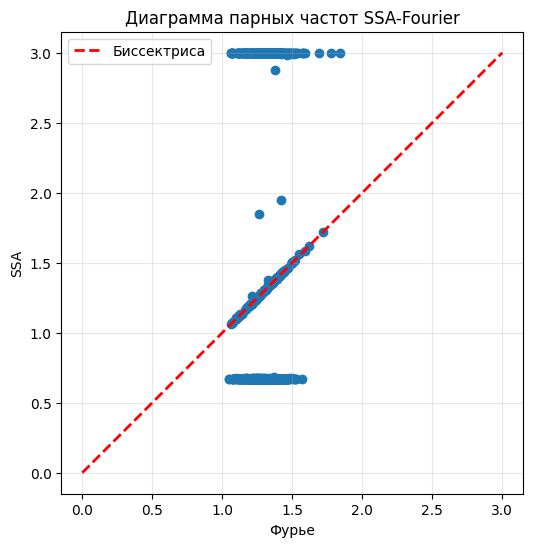

In [20]:
fig, axes = plt.subplots(figsize=(14, 6))
axes.scatter(filtered_frequencies, components_df["freqs"])
max_freq = max(max(filtered_frequencies), max(components_df["freqs"].values))
axes.plot([0, max_freq], [0, max_freq], "r--", linewidth=2, label="Биссектриса")
axes.set_xlabel("Фурье")
axes.set_ylabel("SSA")
axes.set_title("Диаграмма парных частот SSA-Fourier")
axes.legend()
axes.grid(True, alpha=0.3)
axes.set_aspect("equal", adjustable="box")